# Adding weights to rolling window features

[Feature Engineering for Time Series Forecasting](https://www.trainindata.com/p/feature-engineering-for-forecasting)

In this notebook we demonstrate how to add weights to rolling window features using Pandas and sktime.


## Data set synopsis


We will work with the hourly electricity demand dataset. It is the electricity demand for the state of Victora in Australia from 2002 to the start of 2015. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 4, in the folder "01-Create-Datasets" from this repo.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context("talk")

# Load data

In [2]:
data = pd.read_csv(
    "../Datasets/victoria_electricity_demand.csv",
    usecols=["demand", "temperature", "date_time"],
    index_col=["date_time"],
    parse_dates=["date_time"],
)

In [3]:
# For this demo we will use a subset of the data
data = data.loc["2010":]

In [4]:
data.head()

,demand,temperature
date_time,,
2010-01-01 00:00:00,8314.448682,21.525
2010-01-01 01:00:00,8267.187296,22.400
2010-01-01 02:00:00,7394.528444,22.150
2010-01-01 03:00:00,6952.047520,21.800
2010-01-01 04:00:00,6867.199634,20.250


# Computing weighted rolling windows features using Pandas

In [5]:
# Create a copy of the data.
df = data.copy()

Let's compute the rolling weighted mean and weighted standard deviation. To achieve this we need to write our own functions to compute these statistics. The weighted mean and standard deviation are defined as follows:

$$
\mu_w = \frac{\sum_i w_ix_i}{\sum_i w_i}
$$

$$
\sigma_w = \sqrt{\frac{\sum_i w_i(x_i - \mu_w)^2}{\sum_i w_i}}
$$

In [6]:
# Define our own weighted mean function to pass to .apply()
def weighted_mean(x, weights):
    return (weights * x).sum() / weights.sum()

# Define our own weighted std function to pass to .apply()
def weighted_std(x, weights):
    mean_w = weighted_mean(x, weights)
    var_w = (weights * (x - mean_w)**2).sum() / weights.sum()
    return np.sqrt(var_w)

Let's compute the rolling weighted mean and standard deviation. The weights and window size are not independent. They must be the same size.

In [7]:
# Specify weights
# Here we shall use linear weights
weights = np.arange(1, 24 * 7 + 1)  # [1, 2, ..., 168]

# Compute weighted mean
result = (
    df["demand"]
    .rolling(window=24 * 7) # Pick window size. Needs to be same as len(weights).
    .apply(weighted_mean, args=(weights,)) # Apply our custom function.
    .shift(freq="1H") # Lag by 1 hour to avoid data leakage.
    .to_frame() # Convert output from Series to DataFrame.
)  

result.columns = ["demand_weighted_window_168_mean"]

result

,demand_weighted_window_168_mean
date_time,
2010-01-01 01:00:00,NaN
2010-01-01 02:00:00,NaN
2010-01-01 03:00:00,NaN
2010-01-01 04:00:00,NaN
2010-01-01 05:00:00,NaN
...,...
2015-02-28 20:00:00,9466.041052
2015-02-28 21:00:00,9456.912218
2015-02-28 22:00:00,9441.317448


Let's join the result back to our original dataframe.

In [8]:
df = df.join(result, how="left")
df

,demand,temperature,demand_weighted_window_168_mean
date_time,,,
2010-01-01 00:00:00,8314.448682,21.525,NaN
2010-01-01 01:00:00,8267.187296,22.400,NaN
2010-01-01 02:00:00,7394.528444,22.150,NaN
2010-01-01 03:00:00,6952.047520,21.800,NaN
2010-01-01 04:00:00,6867.199634,20.250,NaN
...,...,...,...
2015-02-28 19:00:00,9596.777060,28.350,9466.913081
2015-02-28 20:00:00,8883.230296,22.200,9466.041052
2015-02-28 21:00:00,8320.260550,18.900,9456.912218


Let's compute the weighted standard deviation now.

In [9]:
# Specify weights
weights = np.arange(1, 24 * 7 + 1)  # [1, 2, ..., 168]

# Compute weighted standard deviation
result = (
    df["demand"]
    .rolling(window=24 * 7)  # Pick window size. Needs to be same as len(weights).
    .apply(weighted_std, args=(weights,))  # Apply our custom function.
    .shift(freq="1H")  # Lag by 1 hour to avoid data leakage.
    .to_frame() # Convert output from Series to DataFrame.
)  

result.columns = ["demand_weighted_window_168_std"]

# Join the result back to the original dataframe.
df = df.join(result, how="left")
df

,demand,temperature,demand_weighted_window_168_mean,demand_weighted_window_168_std
date_time,,,,
2010-01-01 00:00:00,8314.448682,21.525,NaN,NaN
2010-01-01 01:00:00,8267.187296,22.400,NaN,NaN
2010-01-01 02:00:00,7394.528444,22.150,NaN,NaN
2010-01-01 03:00:00,6952.047520,21.800,NaN,NaN
2010-01-01 04:00:00,6867.199634,20.250,NaN,NaN
...,...,...,...,...
2015-02-28 19:00:00,9596.777060,28.350,9466.913081,1343.553689
2015-02-28 20:00:00,8883.230296,22.200,9466.041052,1333.021400
2015-02-28 21:00:00,8320.260550,18.900,9456.912218,1324.023135


Let's also compute the unnweighted rolling mean for comparison.

In [10]:
result = (
    df["demand"]
    .rolling(window=24 * 7)  # Pick window size.
    .agg(["mean"])  # Pass our own functions.
    .shift(freq="1H")  # Lag by 1 hour to avoid data leakage.
)  

result

,mean
date_time,
2010-01-01 01:00:00,NaN
2010-01-01 02:00:00,NaN
2010-01-01 03:00:00,NaN
2010-01-01 04:00:00,NaN
2010-01-01 05:00:00,NaN
...,...
2015-02-28 20:00:00,9654.616819
2015-02-28 21:00:00,9638.018555
2015-02-28 22:00:00,9624.108291


In [11]:
result.columns = ["demand_window_168_mean"]

Let's join this back to the original dataframe.

In [12]:
df = df.join(result, how="left")
df

,demand,temperature,demand_weighted_window_168_mean,demand_weighted_window_168_std,demand_window_168_mean
date_time,,,,,
2010-01-01 00:00:00,8314.448682,21.525,NaN,NaN,NaN
2010-01-01 01:00:00,8267.187296,22.400,NaN,NaN,NaN
2010-01-01 02:00:00,7394.528444,22.150,NaN,NaN,NaN
2010-01-01 03:00:00,6952.047520,21.800,NaN,NaN,NaN
2010-01-01 04:00:00,6867.199634,20.250,NaN,NaN,NaN
...,...,...,...,...,...
2015-02-28 19:00:00,9596.777060,28.350,9466.913081,1343.553689,9670.463454
2015-02-28 20:00:00,8883.230296,22.200,9466.041052,1333.021400,9654.616819
2015-02-28 21:00:00,8320.260550,18.900,9456.912218,1324.023135,9638.018555


Text(0.5, 0, 'Time')

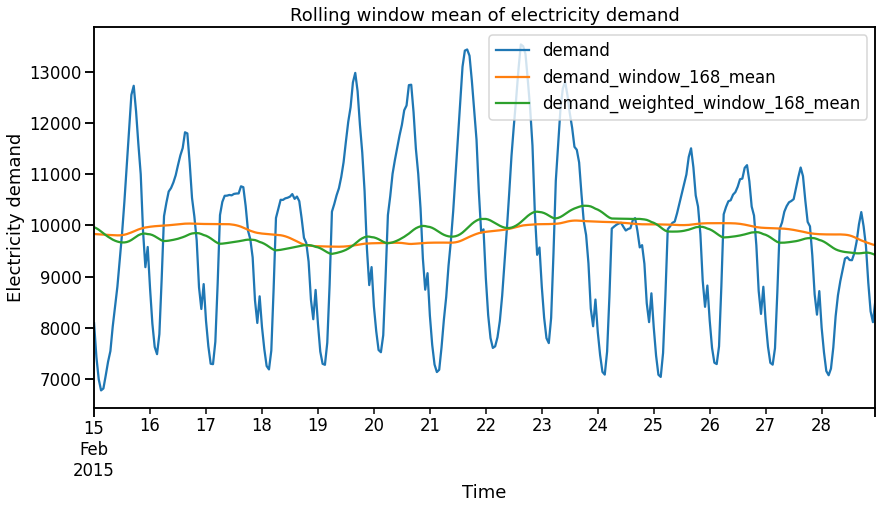

In [13]:
cols = ["demand", "demand_window_168_mean", "demand_weighted_window_168_mean"]

ax = (
    df.iloc[-24 * 7 * 2 :] # Let's look at the last 2 weeks of data
      .loc[:, cols] # Filter to columns of interest
      .plot(figsize=[14, 7])
    )  

ax.set_title("Rolling window mean of electricity demand")
ax.set_ylabel("Electricity demand")
ax.set_xlabel("Time")

As the weighted mean is far more sensitive to recent data we can see how the weighted mean fluctuates more due to the daily seasonality.

If we want to use the weighted window functions to be more responsive to short term **trends** then de-seasonalising the data first may be helpful. See the time series decomposition section on how to de-seasonalise the data. We'll demo this in the 4th notebook of this section.

Overall, we can see the weighted mean moves more quickly (not by much in this case) in response to changing trends in the data.

## `agg` vs `apply`

`agg` was a helpful method because we could pass multiple statistics rather than just one.

Can we use `agg` rather than `apply` now that we have a custom function which takes an argument? 

Yes, but we need to ensure that we don't pass any arguments (e.g., our weights) to our custom function. This can be achieved in multiple ways in Python, let's show two:
- Assigning the arguments inside the function (not efficient as this assignment happens every time the function is called).

```
def f(x):
    weights = np.array([1,2,3])
    ...
```

- Creating a new function from the original function but with some of the arguments pre-set. This is done using `partial` from the in-built functools library (out of scope). Check out the [documentation](https://docs.python.org/3/library/functools.html) for more details.

```
from functools import partial

def f(x, weights):
    ...
    
f_new = partial(f, weights=np.array([1,2,3]))
```

Also, the number of weights needs to match the window size.

In [14]:
# Define our own weighted mean function with weights defined inside
def weighted_mean(x):
    weights = np.arange(1, 24 * 7 + 1) # [1, 2, ..., 168]
    return (weights * x).sum() / weights.sum()

In [15]:
result = (
    df["demand"]
    .rolling(window=24 * 7)  # Pick window size. Needs to be same as len(weights).
    .agg(["mean", "std", weighted_mean])  # Can include custom functions
    .shift(freq="1H")  # Lag by 1 hour to avoid data leakage.
)  

result

,mean,std,weighted_mean
date_time,,,
2010-01-01 01:00:00,NaN,NaN,NaN
2010-01-01 02:00:00,NaN,NaN,NaN
2010-01-01 03:00:00,NaN,NaN,NaN
2010-01-01 04:00:00,NaN,NaN,NaN
2010-01-01 05:00:00,NaN,NaN,NaN
...,...,...,...
2015-02-28 20:00:00,9654.616819,1526.838185,9466.041052
2015-02-28 21:00:00,9638.018555,1519.920008,9456.912218
2015-02-28 22:00:00,9624.108291,1521.229942,9441.317448


# Using sktime

Let's see how we can extract weighted rolling window features using the sktime library.

In [16]:
from sktime.transformations.series.summarize import WindowSummarizer

In [17]:
# Create a copy of the data.
df = data.copy()

As `WindowSummarizer` does not accept arguments for a custom function, we specify the weights in the function itself.

In [18]:
# Define our own weighted mean function with weights defined inside
def weighted_mean(x):
    weights = np.arange(1, 24*7 + 1) # [1, 2, ..., 168]
    return (weights * x).sum() / weights.sum()

In [19]:
transformer = WindowSummarizer(
    lag_feature={
        "lag": [1, 2, 3], # Lag features.
        "mean": [[1, 12], [1, 3]], # [[lag, window size]]
        "std": [[1, 12], [3, 12]],
        weighted_mean: [[1, 24 * 7]], # Can pass custom functions.
    },
    target_cols=["demand"],
)

result = transformer.fit_transform(df)
result

,demand_lag_1,demand_lag_2,demand_lag_3,demand_mean_1_12,demand_mean_1_3,demand_std_1_12,demand_std_3_12,demand_weighted_mean_1_168,temperature
date_time,,,,,,,,,
2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.525
2010-01-01 01:00:00,8314.448682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.400
2010-01-01 02:00:00,8267.187296,8314.448682,NaN,NaN,NaN,NaN,NaN,NaN,22.150
2010-01-01 03:00:00,7394.528444,8267.187296,8314.448682,NaN,7992.054807,NaN,NaN,NaN,21.800
2010-01-01 04:00:00,6952.047520,7394.528444,8267.187296,NaN,7537.921087,NaN,NaN,NaN,20.250
...,...,...,...,...,...,...,...,...,...
2015-02-28 19:00:00,9979.909902,10258.585392,10019.921572,9453.296237,10086.138955,468.988596,658.090105,9466.913081,28.350
2015-02-28 20:00:00,9596.777060,9979.909902,10258.585392,9533.335885,9945.090785,392.623251,555.335360,9466.041052,22.200
2015-02-28 21:00:00,8883.230296,9596.777060,9979.909902,9531.087995,9486.639086,396.572553,468.988596,9456.912218,18.900


In [20]:
df = result.join(df["demand"], how="left")
df

,demand_lag_1,demand_lag_2,demand_lag_3,demand_mean_1_12,demand_mean_1_3,demand_std_1_12,demand_std_3_12,demand_weighted_mean_1_168,temperature,demand
date_time,,,,,,,,,,
2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.525,8314.448682
2010-01-01 01:00:00,8314.448682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.400,8267.187296
2010-01-01 02:00:00,8267.187296,8314.448682,NaN,NaN,NaN,NaN,NaN,NaN,22.150,7394.528444
2010-01-01 03:00:00,7394.528444,8267.187296,8314.448682,NaN,7992.054807,NaN,NaN,NaN,21.800,6952.047520
2010-01-01 04:00:00,6952.047520,7394.528444,8267.187296,NaN,7537.921087,NaN,NaN,NaN,20.250,6867.199634
...,...,...,...,...,...,...,...,...,...,...
2015-02-28 19:00:00,9979.909902,10258.585392,10019.921572,9453.296237,10086.138955,468.988596,658.090105,9466.913081,28.350,9596.777060
2015-02-28 20:00:00,9596.777060,9979.909902,10258.585392,9533.335885,9945.090785,392.623251,555.335360,9466.041052,22.200,8883.230296
2015-02-28 21:00:00,8883.230296,9596.777060,9979.909902,9531.087995,9486.639086,396.572553,468.988596,9456.912218,18.900,8320.260550


So now we've shown how to create rolling window features with weights using different libraries. 